In [1]:
import os

def import_from_directory(directory, module_name):
    current_dir = os.getcwd()
    os.chdir(directory)
    module = __import__(module_name)
    os.chdir(current_dir)
    return module

model_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'model_base')

2024-05-03 09:40:27.110128: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 09:40:27.147172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 09:40:27.147215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 09:40:27.148281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 09:40:27.154677: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
model_base.set_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/notebooks/'
os.chdir(desired_directory)

In [3]:
import pandas as pd
from keras.models import load_model

In [4]:
df = pd.read_csv('Data/tabledata_all.csv')
df_pos = df[df['Adducttype'].str.contains('\]\+') | df['Adducttype'].str.contains('\]2\+')]
df_pos2 = model_base.cal_df_sel_column(df_pos)
df_pos_wide = model_base.cal_wide_df(df_pos2)

/home/jovyan/work/spectrum/notebooks/src/model_base.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'ID'] = df['datasetID'].astype(str)  + '_' + df['AlignmentID'].astype(str)


In [5]:
columnlist_path = 'Data/model_data/pos/posmodelcolumn_all.pkl'
replacement_dict_path = 'Data/model_data/pos/pos_replacement_dict_all.pkl'
y_test_path = 'Data/model_data/pos/df_pos_ytest.csv'

df_pos_wide2, X_train, X_test, X_eval, y_train, y_test, y_eval, train_d, test_d, y, replacement_dict = \
    model_base.train_test_split_from_df(df_pos_wide, columnlist_path, replacement_dict_path, y_test_path) #split data

y_train_onehot, y_test_onehot, y_eval_onehot = model_base.replace_y_onthot(y, y_train, y_test, y_eval, replacement_dict) #onehot

In [6]:
y_train_replaced0, y_test_replaced0, y_eval_replaced0 = model_base.replace_y_number(y, y_train, y_test, y_eval, replacement_dict)

ランダムフォレスト

In [7]:
rf_accuracy, rf_precision, rf_recall, rf_f1 =\
    model_base.rf_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
100%|██████████| 1/1 [05:10<00:00, 310.78s/it]

best score
parameter:{'n_estimators': 300, 'max_depth': 40, 'criterion': 'gini'}
0.9142519219396806 0.7669943629053977 0.6767035678842164 0.6988974205170855



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [10]:
def svm_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0):
    SVC_random_grid = {SVC(): {"C": [0.0, 0,5, 1.0],  
                                "kernel": ["linear", "rbf", "sigmoid"],
                                "decision_function_shape": ["ovo", "ovr"]}}

    # ランダムサーチ
    max_score = 0
    for model, param in SVC_random_grid.items():
        clf = RandomizedSearchCV(model, param_distributions=param, n_iter=100)
        clf.fit(X_train, y_train_replaced0)
        pred_y = clf.predict(X_test)
        score = accuracy_score(y_test_replaced0, pred_y)

        if max_score < score:
            max_score = score
            best_param = clf.best_params_

    print('best score')
    print("parameter:{}".format(best_param))

    # 最適なモデルで予測と評価
    svm_y_pred = clf.predict(X_test)
    svm_accuracy = accuracy_score(y_test_replaced0, svm_y_pred)
    svm_precision = precision_score(y_test_replaced0, svm_y_pred, average='macro') 
    svm_recall = recall_score(y_test_replaced0, svm_y_pred, average='macro')
    svm_f1 = f1_score(y_test_replaced0, svm_y_pred, average='macro')

    print(svm_accuracy, svm_precision, svm_recall, svm_f1)

    return svm_accuracy, svm_precision, svm_recall, svm_f1


In [11]:
svm_accuracy, svm_precision, svm_recall, svm_f1 =\
    svm_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklear

best score
parameter:{'kernel': 'linear', 'decision_function_shape': 'ovo', 'C': 1.0}
0.9319929036073329 0.9126126231071585 0.8745871045093063 0.8818709812678406


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


knn

In [12]:
knn_accuracy, knn_precision, knn_recall, knn_f1 =\
    model_base.knn_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


best score
parameter:{'weights': 'uniform', 'p': 2, 'n_neighbors': 1}
0.9207569485511532 0.8852832002025173 0.8375184827188599 0.8503754503236526


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NN

In [13]:
model = load_model('models/pos_class_model')

In [14]:
nn_accuracy, nn_precision, nn_recall, nn_f1 =\
    model_base.nn_score_summary(model, X_test, y_test_onehot)

53/53 [==============================] - 0s 6ms/step
0.9491425192193969 0.8933028341183106 0.8635922077960184 0.8661459896278242


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def models_perf_plot(SVM, KNN, RF, NN, save_path, title = 'Evaluation of learning methods'):
    fig, ax = plt.subplots(figsize=(6, 5))

    x_labels = ['Accuracy', 'Precision', 'Recall', 'F1 score']

    # 棒グラフを描画
    bar_width = 0.15  # 棒の幅
    index = np.arange(len(x_labels))  # X軸の位置

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #, 'tab:purple']

    plt.bar(index - 1.5 * bar_width, SVM, bar_width, label='SVM', align='center', color=colors[0], alpha=0.5)
    plt.bar(index - bar_width/2, KNN, bar_width, label='KNN', align='center', color=colors[1], alpha=0.5)
    plt.bar(index + bar_width/2, RF, bar_width, label='Random Forest', align='center', color=colors[2], alpha=0.5)
    plt.bar(index + 1.5 * bar_width, NN, bar_width, label='Neural Network', align='center', color=colors[3], alpha=0.9)
    # X軸のラベルとタイトルを設定
    plt.xlabel(' ', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(index, x_labels, fontsize=12)
    plt.title(title, fontsize=13)

    # 凡例を表示
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.ylim([0, 1])

    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()

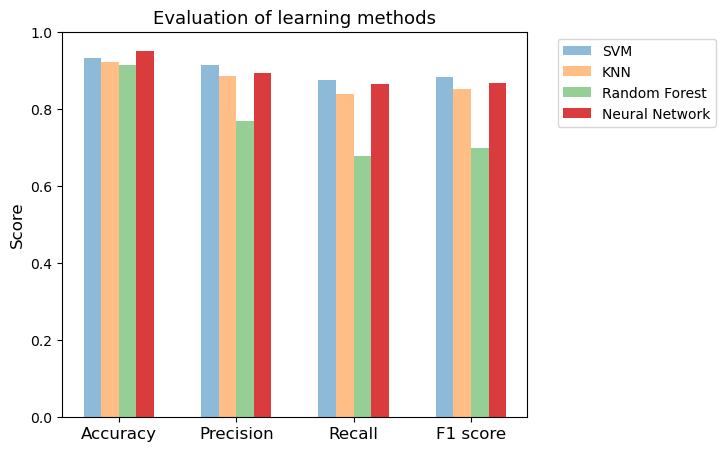

In [17]:
save_path = 'Data/model_data/pos/pos_class_model_perf.svg'
SVM = [svm_accuracy, svm_precision, svm_recall, svm_f1]
KNN = [knn_accuracy, knn_precision, knn_recall, knn_f1]
RF = [rf_accuracy, rf_precision, rf_recall, rf_f1]
NN = [nn_accuracy, nn_precision, nn_recall, nn_f1]

model_base.models_perf_plot(SVM, KNN, RF, NN, save_path)